In [1]:
import sys
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np

sys.path.append("..")

from magnetic_isolation.solutions import theta_values

We will plot in the 2D plane with the different $\hat{k}$ and $\hat{\beta}$ values in order to see if there exists any kind of bpundary where the amount of solutions increases or dicreases... And even more important, in which pairs there is no solution

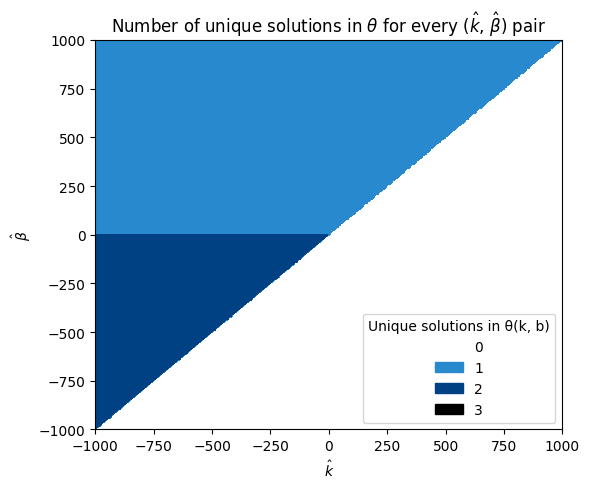

In [2]:
count_unique = lambda k, b: len(np.unique(theta_values(k, b)))  # Assuming theta_values is defined

min_k = -1000
max_k = 1000
min_b = -1000
max_b = 1000
n_points = 400

k = np.linspace(min_k, max_k, n_points)
b = np.linspace(min_b, max_b, n_points)
K, B = np.meshgrid(k, b)
Z = np.vectorize(count_unique)(K, B)

levels = np.arange(0, 4)
colors = ["#FFFFFF", "#2989ce", "#004183", "#000000"] 

plt.figure(figsize=(6, 5))
contour = plt.contourf(K, B, Z, levels=levels, colors=colors, extend='both')

legend_labels = [str(i) for i in range(4)]
legend_patches = [Patch(color=color, label=label) for color, label in zip(colors, legend_labels)]

plt.legend(handles=legend_patches, title='Unique solutions in θ(k, b)', loc='lower right')

plt.xlabel('$\\hat{k}$')
plt.ylabel('$\\hat{\\beta}$')
plt.title('Number of unique solutions in $\\theta$ for every ($\\hat{k}$, $\\hat{\\beta}$) pair')
plt.tight_layout()
plt.show()

We can see there is a linear boundary between having a solution and not having them, then we can say that there is a relationship between the parameters and the existing solutions!

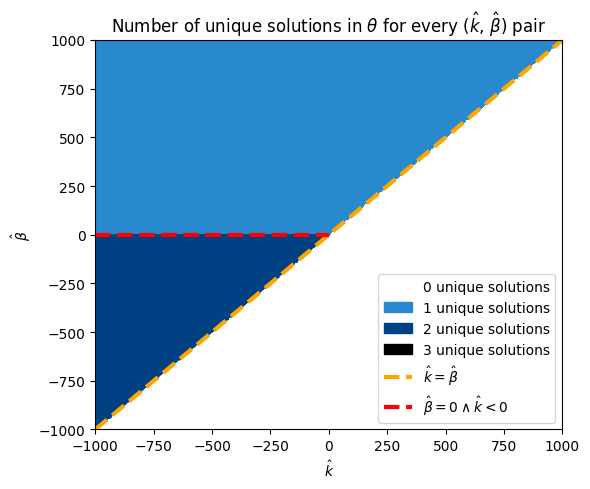

In [3]:
count_unique = lambda k, b: len(np.unique(theta_values(k, b)))
min_k = -1000
max_k = 1000
min_b = -1000
max_b = 1000
n_points = 400

k = np.linspace(min_k, max_k, n_points)
b = np.linspace(min_b, max_b, n_points)
K, B = np.meshgrid(k, b)
Z = np.vectorize(count_unique)(K, B)

levels = np.arange(0, 4)
colors = ["#FFFFFF", "#2989ce", "#004183", "#000000"] 

plt.figure(figsize=(6, 5))
contour = plt.contourf(K, B, Z, levels=levels, colors=colors, extend='both')
line1, = plt.plot([min_k,max_k], [min_b, max_b], color='orange', linestyle='--', linewidth=3, label = '$\\hat{k} = \\hat{\\beta}$')
line2, = plt.plot([min_k,0], [0, 0], color='red', linestyle='--', linewidth=3, label = '$\\hat{\\beta} = 0 \\wedge \\hat{k} < 0$')

legend_labels = [str(i) + ' unique solutions' for i in range(4)]
legend_patches = [Patch(color=color, label=label) for color, label in zip(colors, legend_labels)]

all_handles = legend_patches + [line1, line2]

plt.legend(handles=all_handles,  loc='lower right')

plt.xlabel('$\\hat{k}$')
plt.ylabel('$\\hat{\\beta}$')
plt.title('Number of unique solutions in $\\theta$ for every ($\\hat{k}$, $\\hat{\\beta}$) pair')
plt.tight_layout()
plt.show()

Now we want to see the boundary that is shown by the type of solutions in $\theta$, we would like to see a boundary for only real and complex with imaginary part solutions

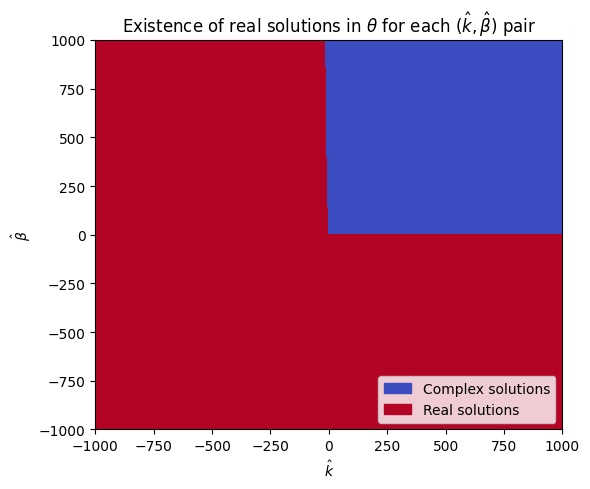

In [4]:
is_real = lambda k, b: int(np.isreal(theta_values(k, b)).any())

min_k, max_k = -1000, 1000
min_b, max_b = -1000, 1000
n_points = 500

k = np.linspace(min_k, max_k, n_points)
b = np.linspace(min_b, max_b, n_points)
K, B = np.meshgrid(k, b)
Z = np.vectorize(is_real)(K, B)

levels = np.arange(0, 2)


plt.figure(figsize=(6, 5))
cmap = plt.get_cmap('coolwarm', 2)
contour = plt.contourf(K, B, Z, cmap=cmap)

colors = [cmap(0), cmap(1)]
legend_labels = ["Complex solutions", "Real solutions"]

legend_patches = [Patch(color=color, label=label) for color, label in zip(colors, legend_labels)]
plt.legend(handles=legend_patches, loc='lower right')

plt.xlabel('$\\hat{k}$')
plt.ylabel('$\\hat{\\beta}$')
plt.title('Existence of real solutions in $\\theta$ for each $(\\hat{k}, \\hat{\\beta})$ pair')
plt.tight_layout()
plt.show()

We can see an specific boundary in the second cuadrant of the plane

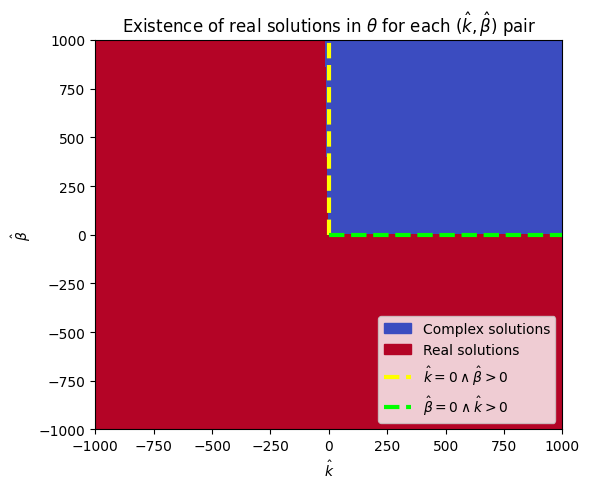

In [5]:
is_real = lambda k, b: int(np.isreal(theta_values(k, b)).any())

min_k, max_k = -1000, 1000
min_b, max_b = -1000, 1000
n_points = 500

k = np.linspace(min_k, max_k, n_points)
b = np.linspace(min_b, max_b, n_points)
K, B = np.meshgrid(k, b)
Z = np.vectorize(is_real)(K, B)

levels = np.arange(0, 2)


plt.figure(figsize=(6, 5))
cmap = plt.get_cmap('coolwarm',2)
contour = plt.contourf(K, B, Z, cmap=cmap)
line1, = plt.plot([0,0], [0, max_b], color='yellow', linestyle='--', linewidth=3, label = '$\\hat{k} = 0 \\wedge \\hat{\\beta} > 0$')
line2, = plt.plot([0,max_k], [0, 0], color='lime', linestyle='--', linewidth=3, label = '$\\hat{\\beta} = 0 \\wedge \\hat{k} > 0$')

colors = [cmap(0), cmap(1)]
legend_labels = ["Complex solutions", "Real solutions"]

legend_patches = [Patch(color=color, label=label) for color, label in zip(colors, legend_labels)]
plt.legend(handles=legend_patches + [line1,line2], loc='lower right')

plt.xlabel('$\\hat{k}$')
plt.ylabel('$\\hat{\\beta}$')
plt.title('Existence of real solutions in $\\theta$ for each $(\\hat{k}, \\hat{\\beta})$ pair')
plt.tight_layout()
plt.show()